In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter

In [2]:
import blosum as bl
matrix = bl.BLOSUM(62)

1. Load the dataset 

In [3]:
#load training data (will be put in a function later) 
#TO CHANGE
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'clean_train_data.csv')
train_df = train_df.drop(columns=['data_source1'])
train_df = train_df.drop(columns=['data_source2'])

train_df = train_df.drop(columns=['protSeq2'])
train_df = train_df.drop(columns=['tm1'])
train_df = train_df.drop(columns=['tm2'])
train_df = train_df.drop(columns=['group1'])
train_df = train_df.drop(columns=['group2'])

train_df = train_df.dropna()

train_df.head()
#dT = 'target'

,protSeq1,operation,position1,position2,change1,change2,pH1,pH2,target
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,D,6.5,6.5,-6.7
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,E,6.5,6.5,-3.9
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,F,6.5,6.5,-1.2
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,G,6.5,6.5,-4.0
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,L,6.5,6.5,2.7


In [4]:
test_df = pd.read_csv(path+ 'test_mutations.csv', index_col="seq_id")
test_df = test_df.drop(columns=['data_source'])
test_df = test_df.drop(columns=['b_factor'])
test_df = test_df.drop(columns=['bFactorAdj'])
test_df = test_df.drop(columns=['score'])
test_df = test_df.drop(columns=['position1'])
test_df = test_df.drop(columns=['position2'])

test_df = test_df[test_df['pH']==8]

test_df.head()

,protein_sequence,pH,modif,score_adj,operation,change1,change2
seq_id,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,E,L
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,K,L
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,16,0.999955,delete,K,NaN
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,C,K
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,F,K


In [5]:
test_df['length'] = test_df['protein_sequence'].str.len()


2. Translate Amino-acids to numbers and create a One-Channel array for each sequence

In [6]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protSeq1'].str.len()
train_df['protein_sequence'] = train_df['protSeq1']
train_df = train_df.drop(columns=['protSeq1'])



In [7]:
#Put the distance of the 2 aa as a feature, with blosum: 
#hypothesis : this score influences the delta Tm. 
#Allows to encode the "mutation" and the info : which aa into which aa

def blosum_apply(row):
        if (row['operation']=='replace'):
            res = matrix[row['change1'] + row['change2']]
        else:
                res = -10
        return res

train_df['dist_mutation'] = train_df.apply(blosum_apply, axis=1)
test_df['dist_mutation'] = test_df.apply(blosum_apply, axis=1)


    

In [8]:
test_df = test_df.drop(columns=['change1'])
test_df = test_df.drop(columns=['change2'])


In [9]:
train_df = train_df.drop(columns=['change1'])
train_df = train_df.drop(columns=['change2'])

In [10]:
train_df.head()

,operation,position1,position2,pH1,pH2,target,length,protein_sequence,dist_mutation
0,replace,2,2,6.5,6.5,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0
1,replace,2,2,6.5,6.5,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0
2,replace,2,2,6.5,6.5,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0
3,replace,2,2,6.5,6.5,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0
4,replace,2,2,6.5,6.5,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0


In [11]:
test_df.head()

,protein_sequence,pH,modif,score_adj,operation,length,dist_mutation
seq_id,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,221,-3.0
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,221,-2.0
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,16,0.999955,delete,220,-10.0
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,221,-3.0
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,221,-3.0


In [12]:
#Compute the relative position of the mutation

train_df['relative_position'] = train_df['position1']/train_df['length']
train_df = train_df.drop(columns=['position1'])
train_df = train_df.drop(columns=['position2'])





In [13]:
test_df['relative_position'] = test_df['modif']/test_df['length']
test_df = test_df.drop(columns=['modif'])

In [14]:
train_df.head()

,operation,pH1,pH2,target,length,protein_sequence,dist_mutation,relative_position
0,replace,6.5,6.5,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195
1,replace,6.5,6.5,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195
2,replace,6.5,6.5,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195
3,replace,6.5,6.5,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195
4,replace,6.5,6.5,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195


In [15]:
test_df.head()


,protein_sequence,pH,score_adj,operation,length,dist_mutation,relative_position
seq_id,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.880797,replace,221,-3.0,0.072398
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.880797,replace,221,-2.0,0.072398
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,0.999955,delete,220,-10.0,0.072727
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.952574,replace,221,-3.0,0.076923
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,0.952574,replace,221,-3.0,0.076923


In [16]:
#Compute difference of pH
train_df['dPH'] = train_df['pH1']-train_df['pH2']
train_df = train_df.drop(columns=['pH1'])
train_df = train_df.drop(columns=['pH2'])

In [17]:
train_df.head()

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH
0,replace,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
1,replace,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0
2,replace,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
3,replace,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195,0.0
4,replace,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0


In [18]:
test_df['dPH'] =test_df['pH'] - 8
test_df = test_df.drop(columns=['pH'])




In [19]:
test_df = test_df.drop(columns=['score_adj'])

In [20]:
test_df = test_df.drop(columns=['operation'])
trian_df = train_df.drop(columns=['operation'])

In [21]:
test_df.head()

,protein_sequence,length,dist_mutation,relative_position,dPH
seq_id,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.072398,0
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-2.0,0.072398,0
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,220,-10.0,0.072727,0
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.076923,0
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,221,-3.0,0.076923,0


In [22]:
train_df.head()

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH
0,replace,-6.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
1,replace,-3.9,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0
2,replace,-1.2,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-2.0,0.012195,0.0
3,replace,-4.0,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0.0,0.012195,0.0
4,replace,2.7,164,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,-1.0,0.012195,0.0


In [23]:
# fix max_length to be 500

max_length = np.max(train_df['length'])

#drop rows that exceeds this value

#train_df = train_df[train_df['length'] < max_length]

In [24]:
def encode_seq(sequence):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] # aa letters
    char_to_int = dict((c, i) for i, c in enumerate(alphabet)) 
    integer_encoded = [char_to_int[char] for char in sequence] #each character becomes int
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))] #0 for all letters
        letter[value] = 1 #modify the column corresponding to the letter to 1
        onehot_encoded.append(letter) #put in the array (1 letter = 1 array of 20 columns)
    
    ar =   np.transpose(np.array(onehot_encoded))
    zeros = np.zeros([len(alphabet),max_length - len(integer_encoded)] )
    onehot_encoded = np.concatenate((ar, zeros), axis = 1) #zero padding


    return onehot_encoded #we have all arrays, corresponding to the whole sequence


# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x))

In [25]:
train_df=train_df.iloc[np.random.permutation(train_df.index)].reset_index(drop=True)

In [26]:
df = train_df.copy()



In [27]:
df = df.reset_index(drop=True)


In [28]:
test_df = test_df.reset_index(drop=True)

Split to train and validation sets

In [29]:
#splot padded_train_df into train and validation sets (will be put in a function later)
train_df = df.sample(frac=0.8,random_state=24)
val_df = df.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [30]:
print(len(train_df),len(val_df))

1837 459


si met la transformation dans le dataframe : le kernel dies
Si met avant, dans le panda, les dimensions sont pas les bonnes (peut être transposer ??)

In [31]:
df

,operation,target,length,protein_sequence,dist_mutation,relative_position,dPH,encoded_sequence
0,replace,0.3,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-1.0,0.870130,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,replace,-11.3,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-2.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,replace,-3.4,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-1.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,replace,-7.1,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-2.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,replace,6.5,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-1.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
2291,replace,4.0,96,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,-3.0,0.812500,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2292,replace,12.5,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-2.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2293,replace,-10.2,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,-2.0,0.619048,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2294,replace,1.8,231,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,3.0,0.528139,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Create 1d conv net

1. get DataLoader from train_dl

In [32]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
        sequence= df['encoded_sequence']
        
        # numerical : pH and length
        numerical = df[['dPH','length', 'relative_position', 'dist_mutation']].values

        # y : the target (tm)
        if train == True : 
            y=df['target'].values
        else : 
            y = np.zeros(np.shape(numerical)[0])
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx], self.y[idx],self.num[idx]


In [33]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 800


a faire : apres avoir fait one hot encoding, trouver comment mettre l'info de plusieurs channels dans le dataframe, sans qu'il mette d'erreur sur la taille. 
Voir comment mettre un tableau = 1 aa puis la longueur de la ligne = longueur totale (juste transposer ?)


class MyLoss(torch.nn.Module):
    def __init__(self, batch_size, classes):
        super(MyLoss, self).__init__()
        # define some attributes
        self.y_true_one_hot = torch.FloatTensor(batch_size, classes, length)

    def forward(self, y_pred, y_true):
        with torch.no_grad():
            self.y_true_one_hot.zero_().scatter_(1, y_true, 1) # permet one hot encoding
        # do some operations
        return loss


Or use cross entropy loss ?

In [35]:
# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df, train=False)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [36]:
class Conv1D_OneChannel(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            
            nn.Conv1d(20, 10,kernel_size=6, stride=1, padding=3),
            nn.ELU(),
            

            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ELU(), 
            
            
         
            torch.nn.MaxPool1d(10), 
            
            torch.nn.Flatten(),
            torch.nn.Dropout2d(p=0.5, inplace=False),
            
 
            

        )
        self.numerical = nn.Sequential(
            nn.Linear(4, 20),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(20, 100),
            nn.ELU(),
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Linear(100, 4),
            
            
        )
        self.mlp = nn.Sequential(
            nn.Linear(524, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ELU(),
 
            nn.Linear(128, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 1),
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

In [37]:
#Voir pour changer activation fonction
#voir pq probleme de dimension

In [38]:

model = Conv1D_OneChannel()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


In [39]:
def Scoring(df_te, df_predicted):
    df = {
    "true": df_te['target'],
    "predicted": df_predicted['target']
}
    pearson = df.corr(method='pearson')
    rmse = mean_squared_error(df_te['target'], df_predicted['target'], squared=False)
    auc = metrics.roc_auc_score(df_te['target'], df_predicted['target'])
    
    print('Pearson: %.3f, RMSE %.3f, AUC: %.3f' %(pearson, rmse, auc))
    return pearson, rmse, auc

In [40]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (seq, target,num) in enumerate(train_loader):
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(seq,num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
   
    print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss , rho

In [41]:
def test_epoch(model, criterion, test_loader):
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for (seq, target,num) in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    print(
        f"Test set: Average loss: {test_loss:0.2e} "
    )

    return test_loss ,rho

In [42]:
def predict(model,test_loader):
    model = model.eval()
    df_predicted = pd.DataFrame()
    with torch.no_grad():
        for (seq, _,num) in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                #target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            df_predicted = df_predicted.append(pd.DataFrame({'target':output.squeeze().cpu().detach().numpy()}))
    return df_predicted

In [43]:
from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    #torch.save(model.state_dict(), f"2-Conv1d_OneHot_model_{epoch}.pth")


In [44]:
#train model and preditct
train_rho_history = []
train_loss_history = []
test_rho_history = []
test_loss_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    test_loss, rho_test = test_epoch(
        model, criterion, val_dl
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)



/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1  loss=8.34e+01 
Test set: Average loss: 6.57e-02 


/home/ml4science/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Train Epoch: 2  loss=8.33e+01 
Test set: Average loss: 5.06e-03 
Train Epoch: 3  loss=8.37e+01 
Test set: Average loss: 3.58e-03 
Train Epoch: 4  loss=8.36e+01 
Test set: Average loss: 6.12e-03 
Train Epoch: 5  loss=8.34e+01 
Test set: Average loss: 1.68e-03 
Train Epoch: 6  loss=8.32e+01 
Test set: Average loss: 2.09e-03 
Train Epoch: 7  loss=8.33e+01 
Test set: Average loss: 1.03e-02 
Train Epoch: 8  loss=8.32e+01 
Test set: Average loss: 2.23e-03 
Train Epoch: 9  loss=8.34e+01 
Test set: Average loss: 2.36e-03 
Train Epoch: 10  loss=8.39e+01 
Test set: Average loss: 2.54e-03 
Train Epoch: 11  loss=8.33e+01 
Test set: Average loss: 4.77e-03 
Train Epoch: 12  loss=8.34e+01 
Test set: Average loss: 9.45e-03 
Train Epoch: 13  loss=8.33e+01 
Test set: Average loss: 4.83e-03 
Train Epoch: 14  loss=8.34e+01 
Test set: Average loss: 4.46e-03 
Train Epoch: 15  loss=8.31e+01 
Test set: Average loss: 7.76e-03 
Train Epoch: 16  loss=8.33e+01 
Test set: Average loss: 1.39e-02 
Train Epoch: 17  l

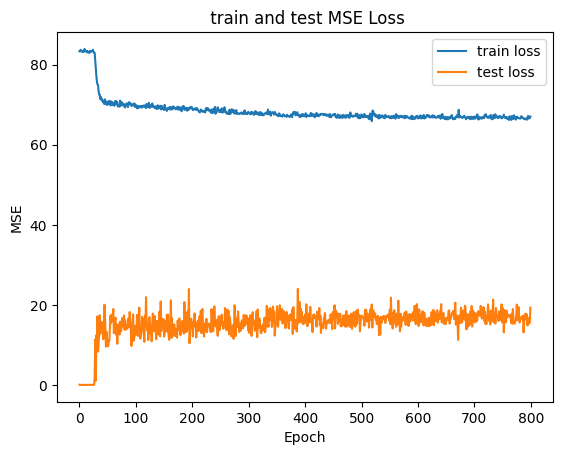

In [45]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
#plt.savefig('2-conv1d_OneHot-Loss-2pool.png')


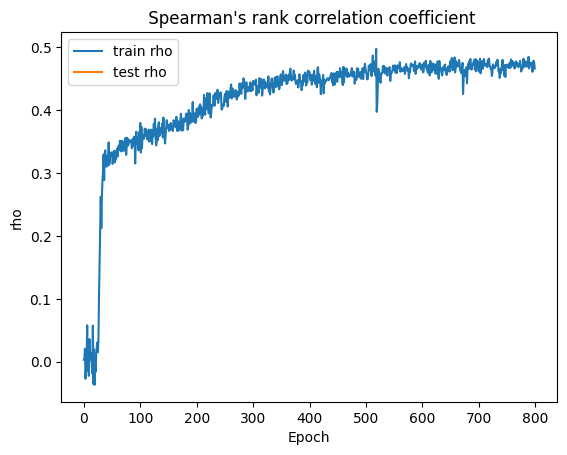

In [46]:
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
#plt.savefig('2-conv1d_OneHot-rho-2pool.png')

In [47]:
test_out= EnzymesDataset(test_df, train=False)

submission_df =  predict(model,test_out)


/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
submission_df

In [ ]:
torch.save(model.state_dict(), f"effect_mutation.pth")

In [ ]:
test_df

In [ ]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df['tm']=submission_df['target'].values
test_df = test_df.drop(columns=['protein_sequence','pH','data_source'])
#submission_df['tm']=submission_df['target'].values
#submission_df['seq_id']=submission_df[''].values
#submission_df=submission_df.drop(columns=['target'])
#submission_df=submission_df.drop(columns=[''])
test_df.to_csv('Effect_mutation_seq.csv', index=True)